# Credit Risk Analysis

In [18]:
# Useful imports
import pandas as pd
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from ax import optimize


# Import models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

## Load Credit Data

In [2]:
from datapackage import Package

package = Package('https://datahub.io/machine-learning/credit-g/datapackage.json')

# print list of all resources:
print(package.resource_names)

# print processed tabular data (if exists any)
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        data = resource.read()

['validation_report', 'credit-g_csv', 'credit-g_json', 'credit-g_zip', 'credit-g_arff', 'credit-g']


### Data Description 


1. Status of existing checking account, in Deutsche Mark.
2. Duration in months
3. Credit history (credits taken, paid back duly, delays, critical accounts)
4. Purpose of the credit (car, television,…)
5. Credit amount
6. Status of savings account/bonds, in Deutsche Mark.
7. Present employment, in number of years.
8. Installment rate in percentage of disposable income
9. Personal status (married, single,…) and sex
10. Other debtors / guarantors
11. Present residence since X years
12. Property (e.g. real estate)
13. Age in years
14. Other installment plans (banks, stores)
15. Housing (rent, own,…)
16. Number of existing credits at this bank
17. Job
18. Number of people being liable to provide maintenance for
19. Telephone (yes,no)
20. Foreign worker (yes,no)

In [3]:
feature_name = [
    "checking_account", "months_duration", "credit_history", "credit_purpose",
    "credit_amount", "savings_status", "present_employ", "install_rate", "personal_status",
    "other_debtors", "present_residence", "property", "age", "installment_plans", "housing_status",
    "n_bank_credits", "job", "dependents", "has_phone", "is_foreign_worker", "label"
]
credit_data = pd.DataFrame(data, columns=feature_name)

In [4]:
credit_data.head()

,checking_account,months_duration,credit_history,credit_purpose,credit_amount,savings_status,present_employ,install_rate,personal_status,other_debtors,...,property,age,installment_plans,housing_status,n_bank_credits,job,dependents,has_phone,is_foreign_worker,label
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [5]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   checking_account   1000 non-null   object
 1   months_duration    1000 non-null   object
 2   credit_history     1000 non-null   object
 3   credit_purpose     1000 non-null   object
 4   credit_amount      1000 non-null   object
 5   savings_status     1000 non-null   object
 6   present_employ     1000 non-null   object
 7   install_rate       1000 non-null   object
 8   personal_status    1000 non-null   object
 9   other_debtors      1000 non-null   object
 10  present_residence  1000 non-null   object
 11  property           1000 non-null   object
 12  age                1000 non-null   object
 13  installment_plans  1000 non-null   object
 14  housing_status     1000 non-null   object
 15  n_bank_credits     1000 non-null   object
 16  job                1000 non-null   object
 

In [6]:
num_features = ['months_duration', 'credit_amount', 'install_rate', 'present_residence',
               'age', 'n_bank_credits', 'dependents']
cat_features = ['checking_account', 'credit_history', 'credit_purpose', 'savings_status',
               'present_employ', 'personal_status', 'other_debtors', 'property', 'installment_plans',
               'housing_status', 'job', 'has_phone', 'is_foreign_worker']

credit_data[num_features] = credit_data[num_features].astype(float)
credit_data[cat_features] = credit_data[cat_features].astype('category')

## EDA

### Plot data distribution

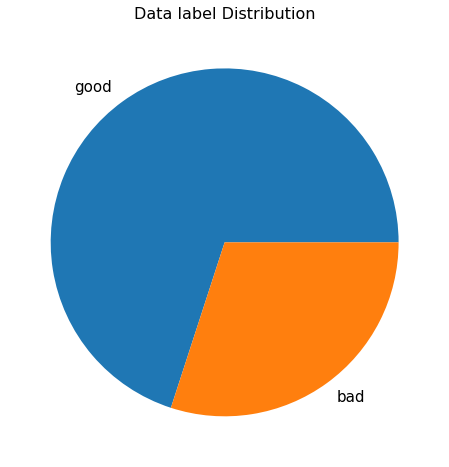

In [7]:
# Check the label distribution
plt.figure(figsize=[8,8])
vcounts = credit_data['label'].value_counts()
plt.pie(vcounts, labels=vcounts.keys(), textprops={'fontsize': 15})
plt.title('Data label Distribution', fontsize=16)
plt.show()

### Show relationship between numerial variables

In [8]:
sns.set_context("paper", rc={"axes.labelsize":16})

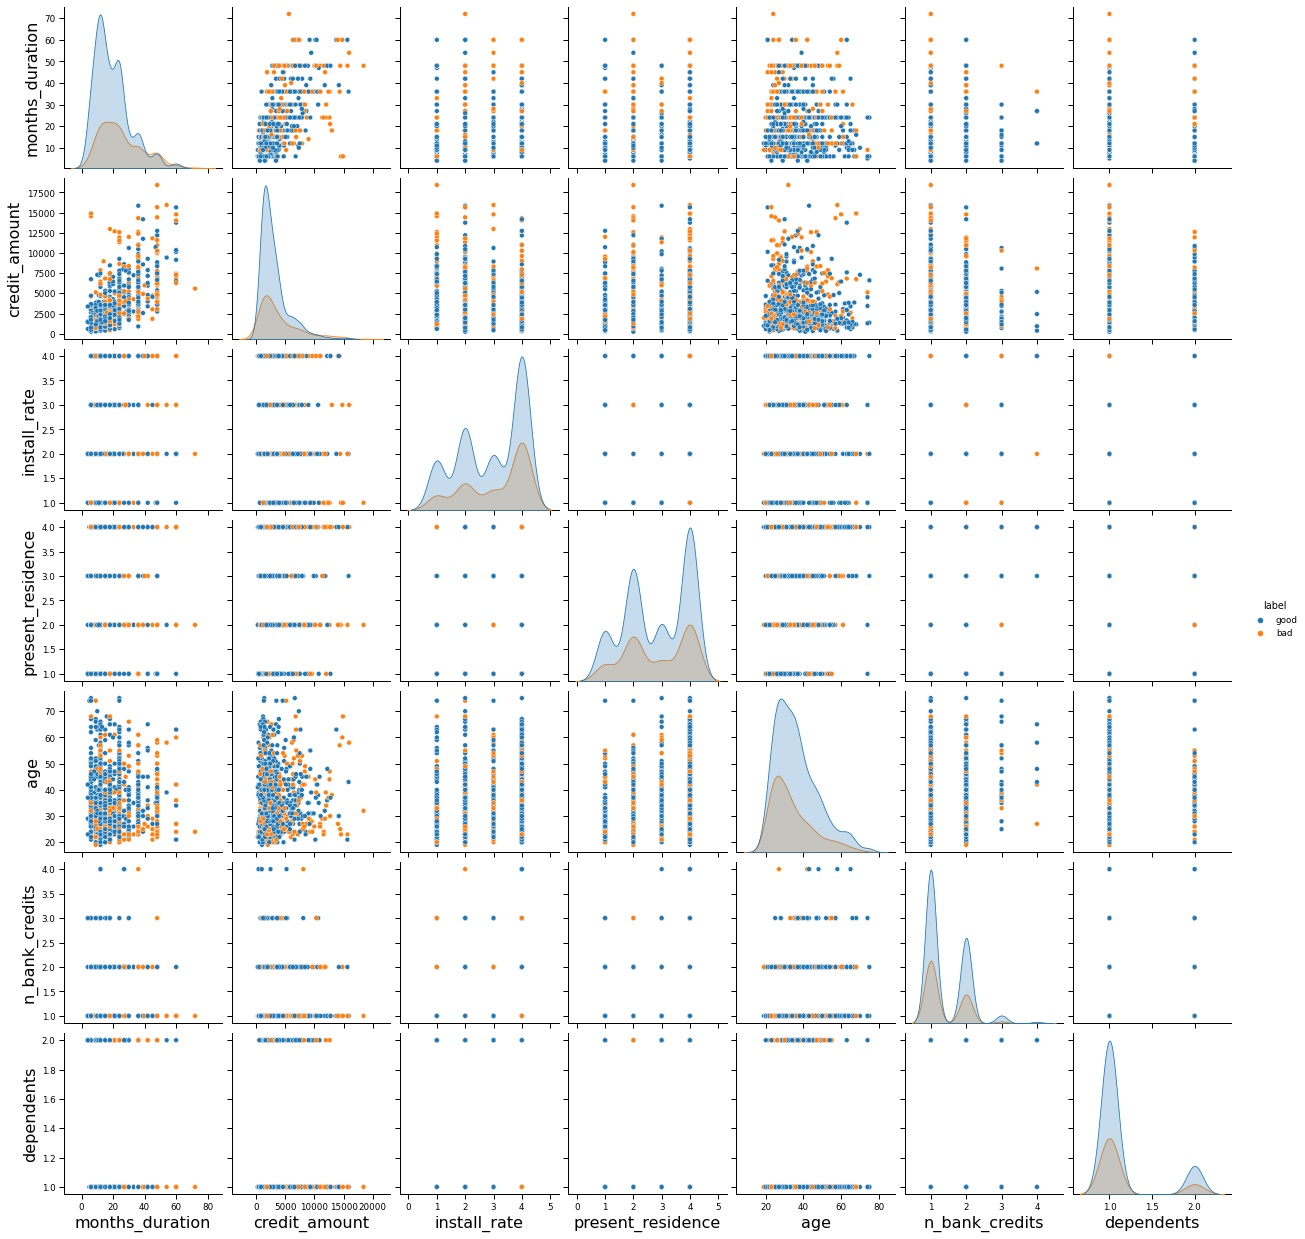

In [9]:
sns.set_context("paper", rc={"axes.labelsize":16})
gfg = sns.pairplot(credit_data[num_features + ['label']], hue='label')
plt.show()

## Modeling 

In [19]:
X, y = credit_data.drop('label', axis=1), credit_data['label']
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

partitions = {}
partitions["train"] = x_train, y_train
partitions["val"] = x_test, y_test

In [132]:
class ModelBuilder:
    def __init__(self, partitions):
        self.x_train, self.y_train = partitions['train']
        self.x_val, self.y_val = partitions['val']  
        
        self.cat_features = x_train.select_dtypes('category').columns
        self.num_features = x_train.select_dtypes('number').columns
    
        ct = ColumnTransformer([
            ('encode', OneHotEncoder(), cat_features),
            ('normalizer', StandardScaler(), num_features)]
        )    
        self.steps = [('transformers', ct)]
        
        
    def create_pipe(self, estimator, params):
        estimator.set_params(**params)
        pipe = Pipeline(self.steps + [("estimator", estimator)])
        return pipe
        
    def build(self, model):
        def model_eval(parameterization, verbose=False):

            estimator = copy(model) 

            # Set params on model and create a pipeline
#             parameterization.update({'verbose': verbose})       
            pipe = self.create_pipe(estimator, parameterization)

            try:
                if isinstance(estimator, CatBoostClassifier):                
                    pipe = estimator.fit(X=self.x_train,
                                         y=self.y_train,
                                         cat_features=self.cat_features)
                else:
                    pipe.fit(X=self.x_train, y=self.y_train)
                    
                # Compute accuracy on validation set
                val_pred = pipe.predict(self.x_val)
                acc_score = accuracy_score(self.y_val, val_pred)
                return acc_score
            except Exception as e:
                print(e)
                return 0.0

        return model_eval

In [148]:

# Set params range
default_param = {"random_state": 100, 
                 "n_jobs": -1}
configs = {
    'lightgbm':{
        'params_range': [
#             {'name': 'num_leaves', 'type': 'range', 'bounds': [10, 40]},              
            {'name': 'max_depth', 'type': 'range', 'bounds': [3,31]},   
#             {'name': 'learning_rate', 'type': 'range', 'bounds': [0.001, 0.3]}, 
            {'name': 'n_estimators', 'type': 'range', 'bounds': [1, 4]},                                                 
#             {'name': 'reg_alpha', 'type': 'range', 'bounds': [0.001,10.0]},           
#             {'name': 'reg_lambda', 'type': 'range', 'bounds': [0.001,10.0]},                       
        ],
        'model_instance': LGBMClassifier(random_state=100)
    },    
#     'catboost': {
#         'params_range':[
#             {'name': 'depth', 'type': 'choice', 'values': [3,1,2,6,4,5,7,8,9,10]},
#             {'name': 'iterations', 'type': 'choice', 'values': [250,100,500,1000]},
#             {'name': 'border_count', 'type': 'choice', 'values': [32,5,10,20,50,100,200]},        
#             {'name': 'learning_rate', 'type': 'choice', 'values': [0.03,0.001,0.01,0.1,0.2,0.3]}],
#         'model_instance': CatBoostClassifier(random_state=100) 
#     },
#     'xgboost': {
#         'params_range': [
#             {'name': 'learning_rate', 'type': 'choice', 'values': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]},            
#             {'name': 'max_depth', 'type': 'choice', 'values': [3, 4, 5, 6, 8, 10, 12, 15]},      
#             {'name': 'min_child_weight', 'type': 'choice', 'values': [1, 3, 5, 7]},             
#             {'name': 'gamma', 'type': 'choice', 'values': [0.0, 0.1, 0.2 , 0.3, 0.4]},             
#             {'name': 'colsample_bytree', 'type': 'choice', 'values': [0.3, 0.4, 0.5 , 0.7]},              
#         ],
#         'model_instance': XGBClassifier(random_state=100)
#     },
#     'rf': {
#         'params_range': [           
#             {'name': 'n_estimators', 'type': 'range', 'bounds': [10,100]},              
#             {'name': 'max_depth', 'type': 'choice', 'values': [3, 4, 5, 6, 8, 10, 12, 15]},                  
#             {'name': 'bootstrap', 'type': 'choice', 'values': [True, False]},  
#             {'name': 'criterion', 'type': 'choice', 'values': ["gini", "entropy"]},            
#             {'name': 'max_features', 'type': 'choice', 'values': ["auto", "sqrt", "log2"]},  
#             {'name': 'class_weight', 'type': 'choice', 'values': ["balanced", "balanced_subsample"]},              
            
#         ],
#         'model_instance': RandomForestClassifier(**default_param)        
#     },
#     'log_reg':{
#         'params_range': [
#             {'name': 'penalty', 'type': 'choice', 'values': ['l1', 'l2', 'elasticnet', 'none']},              
#             {'name': 'C', 'type': 'range', 'bounds': [1.0, 25.0]},   
#             {'name': 'solver', 'type': 'choice', 'values': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}, 
#             {'name': 'max_iter', 'type': 'range', 'bounds': [20, 120]},                                                 
#         ],
#         'model_instance': LogisticRegression(**default_param)
#     },
    'mlp':{
        'params_range': [
            {'name': 'hidden_layer_sizes', 'type': 'range', 'bounds': [20, 100]},              
            {'name': 'activation', 'type': 'choice', 'values': ['identity', 'logistic', 'tanh', 'relu']},   
            {'name': 'solver', 'type': 'choice', 'values': ['lbfgs', 'sgd', 'adam']}, 
            {'name': 'alpha', 'type': 'range', 'bounds': [0.0001, 1.0]},                                                 
            {'name': 'learning_rate', 'type': 'choice', 'values': ['constant', 'invscaling', 'adaptive']},           
        ],
        'model_instance': MLPClassifier(random_state=100)
    }     
            
}

model_builder = ModelBuilder(partitions)

results = {}
for clf_name, config in configs.items():
    eval_method = model_builder.build(model=config["model_instance"])
    
    best_params, best_values, *_ = optimize(
        parameters=config["params_range"],
        evaluation_function=eval_method,
        minimize=False, 
        total_trials=30,
        random_seed=100
        )
    results[clf_name] = (best_params, best_values[0]['objective'])


[INFO 03-13 14:57:55] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_depth. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-13 14:57:55] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter n_estimators. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-13 14:57:55] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 03-13 14:57:55] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 03-13 14:57:55] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-13 14:57:55] ax.service.managed_loop: Running opt

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:57:55] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-13 14:57:56] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-13 14:57:56] ax.service.managed_loop: Running optimization trial 6...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:57:56] ax.service.managed_loop: Running optimization trial 7...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:57:57] ax.service.managed_loop: Running optimization trial 8...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:57:57] ax.service.managed_loop: Running optimization trial 9...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:57:58] ax.service.managed_loop: Running optimization trial 10...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:57:59] ax.service.managed_loop: Running optimization trial 11...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:00] ax.service.managed_loop: Running optimization trial 12...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:01] ax.service.managed_loop: Running optimization trial 13...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:01] ax.service.managed_loop: Running optimization trial 14...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:02] ax.service.managed_loop: Running optimization trial 15...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:03] ax.service.managed_loop: Running optimization trial 16...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:04] ax.service.managed_loop: Running optimization trial 17...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:04] ax.service.managed_loop: Running optimization trial 18...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:05] ax.service.managed_loop: Running optimization trial 19...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:06] ax.service.managed_loop: Running optimization trial 20...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:07] ax.service.managed_loop: Running optimization trial 21...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:08] ax.service.managed_loop: Running optimization trial 22...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:08] ax.service.managed_loop: Running optimization trial 23...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:09] ax.service.managed_loop: Running optimization trial 24...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:10] ax.service.managed_loop: Running optimization trial 25...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:10] ax.service.managed_loop: Running optimization trial 26...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:11] ax.service.managed_loop: Running optimization trial 27...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:12] ax.service.managed_loop: Running optimization trial 28...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:13] ax.service.managed_loop: Running optimization trial 29...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:14] ax.service.managed_loop: Running optimization trial 30...


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[INFO 03-13 14:58:14] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter hidden_layer_sizes. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-13 14:58:14] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter activation. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-13 14:58:14] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter solver. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-13 14:58:14] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter alpha. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[INFO 03-13 14:58:15] ax.service.managed_loop: Running optimization trial 2...
/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

[INFO 03-13 14:58:16] ax.service.managed_loop: Running optimization trial 3...
/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[INFO 03-13 14:58:29] ax.service.managed_loop: Running optimization trial 29...
/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

[INFO 03-13 14:58:29] ax.service.managed_loop: Running optimization trial 30...
/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn

In [184]:
get_score = lambda r: r[1][1]

a = {'lightgbm': ({'max_depth': 14, 'n_estimators': 4}, 0.6933337825395494),
 'mlp': ({'hidden_layer_sizes': 52,
   'alpha': 0.758171814214997,
   'activation': 'logistic',
   'solver': 'lbfgs',
   'learning_rate': 'constant'},
  0.9)}
b = sorted(a.items(), key=get_score)[-1]


In [191]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(b, f)

with open('model.pkl', 'rb') as f:
    g= pickle.load(f)    
g    

('mlp',
 ({'hidden_layer_sizes': 52,
   'alpha': 0.758171814214997,
   'activation': 'logistic',
   'solver': 'lbfgs',
   'learning_rate': 'constant'},
  0.9))

In [170]:
results.items()

dict_items([('lightgbm', ({'max_depth': 14, 'n_estimators': 4}, 0.6933337825395494)), ('mlp', ({'hidden_layer_sizes': 52, 'alpha': 0.758171814214997, 'activation': 'logistic', 'solver': 'lbfgs', 'learning_rate': 'constant'}, 0.7733333333333333))])

In [130]:
from sklearn.model_selection import StratifiedKFold

def cv_score(clf, params, X, y, n_folds=10):
    kfold = StratifiedKFold(n_folds)
    scores = []
    for itrain, ival in kfold.split(X, y):        
        partitions = {}
        partitions['train'] = X.iloc[itrain], y.iloc[itrain]
        partitions['val'] = X.iloc[ival], y.iloc[ival]  
        eval_method = ModelBuilder(partitions).build(clf)        
        scores.append(eval_method(params))
    return scores


In [135]:
fitted_models = {}
for clf_name, bp in results.items():
    if clf_name == 'lightgbm':
        bp['verbose'] = 0
    estimator = configs[clf_name]["model_instance"]    
    score = cv_score(estimator, bp, x_train, y_train)
    fitted_models[clf_name] = score

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leav

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:16:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:16:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:16:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:16:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:16:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:16:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:16:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:16:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:16:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:16:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:16:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:16:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/pierdig/opt/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/pierdig/opt/a

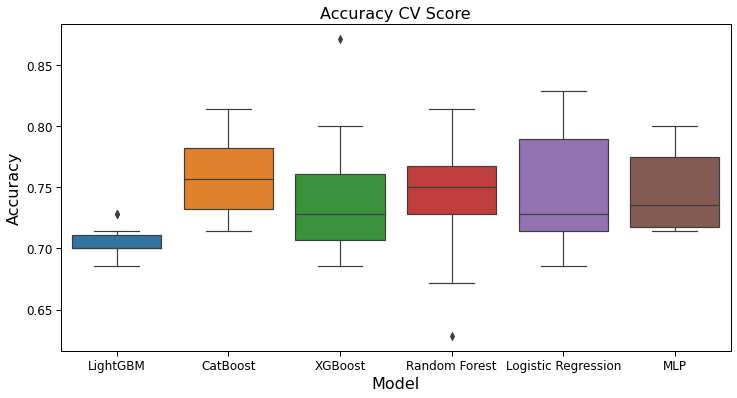

In [138]:
cv_scores = pd.DataFrame(fitted_models)

plt.figure(figsize=[12, 6])
cv_scores = cv_scores.stack().reset_index()\
    .rename(columns={'level_1': 'Model', 0:'Accuracy'})
cv_scores['Model'] = cv_scores['Model'].map(
            {'mlp': 'MLP', 
             'log_reg': 'Logistic Regression',
             'rf': 'Random Forest',
             'xgboost': 'XGBoost',
             'catboost': 'CatBoost',
             'lightgbm': 'LightGBM'}
)
im = sns.boxplot(x='Model', y='Accuracy', data=cv_scores)
im.tick_params(labelsize=12)
plt.title('Accuracy CV Score', fontsize=16)
plt.show()
